<a href="https://colab.research.google.com/github/yujongwon0103/Section2_Project/blob/main/prediction_of_movie_attendance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting
모듈 설치 및 케글 데이터셋 불러오기

In [ ]:
!pip install kaggle
!pip install category_encoders
!pip install pandas-profiling==2.*

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yujongwon","key":"a518b80a121663da913e850dee696f50"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d omkarborikar/top-10000-popular-movies

!unzip /content/top-10000-popular-movies.zip

  0% 0.00/1.72M [00:00<?, ?B/s]
100% 1.72M/1.72M [00:00<00:00, 138MB/s]
Archive:  /content/top-10000-popular-movies.zip
  inflating: Top_10000_Movies.csv    


# EDA

##1. 데이터셋 설명

In [ ]:
import pandas as pd

df = pd.read_csv("Top_10000_Movies.csv", lineterminator='\n', index_col=0)
df.shape

(10000, 12)

In [ ]:
df.columns

Index(['id', 'original_language', 'original_title', 'popularity',
       'release_date', 'vote_average', 'vote_count', 'genre', 'overview',
       'revenue', 'runtime', 'tagline'],
      dtype='object')

칼럼 설명
1. id : 영화의 고유 ID값

2. original_language : 영화의 주 언어
- 이 열에는 총 44개의 언어가 있다.
- 'en'를 원어로 한 영화는 총 7771편이다. 
- 이 열의 값은 ISO 639-1 언어 코드입니다.
- 'en'은 'English', 'Hindi'는 'Hi' 등을 의미한다.

3. original_title : 영화의 제목

4. popularity	: 영화의 인기

5. release_date	: 영화의 개봉일(결측치일 경우, 개봉예정영화)

6. vote_average : 영화 평점

7. vote_count : 영화 평점 개수

8. genre : 영화의 장르

9. overview : 영화의 간략한 소개

10. revenue : 영화의 수익

11. runtime : 영화의 러닝타임(분단위)

12. tagline : 영화의 태그라인(포스터 문구)

In [ ]:
df.head()

id original_language               original_title  popularity  \
0  580489                en  Venom: Let There Be Carnage    5401.308   
1  524434                en                     Eternals    3365.535   
2  438631                en                         Dune    2911.423   
3  796499                en              Army of Thieves    2552.437   
4  550988                en                     Free Guy    1850.470   

  release_date  vote_average  vote_count  \
0   2021-09-30           6.8        1736   
1   2021-11-03           7.1         622   
2   2021-09-15           8.0        3632   
3   2021-10-27           6.9         555   
4   2021-08-11           7.8        3493   

                                               genre  \
0         ['Science Fiction', 'Action', 'Adventure']   
1  ['Action', 'Adventure', 'Science Fiction', 'Fa...   
2         ['Action', 'Adventure', 'Science Fiction']   
3                    ['Action', 'Crime', 'Thriller']   
4  ['Comedy', 'Action', 'Adventure', 'Science Fic...   

                                            overview    revenue  runtime  \
0  After finding a host body in investigative rep...  424000000     97.0   
1  The Eternals are a team of ancient aliens who ...  165000000    157.0   
2  Paul Atreides, a brilliant and gifted young ma...  331116356    155.0   
3  A mysterious woman recruits bank teller Ludwig...          0    127.0   
4  A bank teller called Guy realizes he is a back...  331096766    115.0   

                                          tagline  
0                                             NaN  
1                             In the beginning...  
2                    Beyond fear, destiny awaits.  
3    Before Vegas, one locksmith became a legend.  
4  Life's too short to be a background character.

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

판다스 프로파일링으로 데이터프레임을 확인해 본 결과, 수치형 변수 6개, 범주형 변수 6개로 구성되어 있고, 결측치는 총 3,067개, 중복 데이터는 없는 것을 확인할 수 있습니다.

판다스 프로파일링의 경고창을 보면 15개의 경고 문구가 있습니다.
1. High cardinality
- original_title has a high cardinality: 9756 distinct values
- release_date has a high cardinality: 5727 distinct values
- genre has a high cardinality: 2314 distinct values
- overview has a high cardinality: 9895 distinct values
- tagline has a high cardinality: 7042 distinct values

original_title, release_date, genre, overview, tagline 중 범주형 변수로 사용이 가능한 변수는 genre이고 나머지 변수들은 영화 고유의 정보로 범주를 제한하기 어려워 범주형 변수로 사용이 불가능합니다. 그래서 genre열의 모든 범주를 열로 변환해줘야 합니다.

2. Missing
- tagline has 2920 (29.2%) missing values

tagline에 결측치가 3,067개 중 2,920개 존재하고 있습니다. 결측치 처리를 해줘야 합니다.

3. Skewed
- popularity is highly skewed (γ1 = 25.98193426)

popularity의 데이터는 연속성을 띠지 않기 때문에 발생하는 문제입니다.

4. Uniform
- original_title is uniformly distributed
- overview is uniformly distributed
- tagline is uniformly distributed

original_title, overview, tagline는 균등하게 분포된 데이터이고 앞서 설명드린 High cardinality에서의 설명처럼 영화 고유의 정보임을 나타냅니다.

5. Unique
- id has unique values

id는 고유값으로 중복되는 데이터가 없음을 나타냅니다.

6. Zeros
- vote_average has 275 (2.8%) zeros
- vote_count has 275 (2.8%) zeros
- revenue has 4658 (46.6%) zeros
- runtime has 231 (2.3%) zeros

vote_average, vote_count, revenue, runtime에 0인 값들이 존재함을 의미하고 그 중 revenue에 절반 가까인 존재함을 의미합니다. 0인 값들이 왜 존재하는지 확인해야 합니다.

## 2. 데이터 타입 확인

In [ ]:
df.dtypes

id                     int64
original_language     object
original_title        object
popularity           float64
release_date          object
vote_average         float64
vote_count             int64
genre                 object
overview              object
revenue                int64
runtime              float64
tagline               object
dtype: object

In [ ]:
df.nunique()

id                   10000
original_language       47
original_title        9756
popularity            8596
release_date          5727
vote_average            73
vote_count            3208
genre                 2314
overview              9895
revenue               5213
runtime                215
tagline               7042
dtype: int64

## 3. 데이터 중복 확인

In [ ]:
df.T.duplicated()

id                   False
original_language    False
original_title       False
popularity           False
release_date         False
vote_average         False
vote_count           False
genre                False
overview             False
revenue              False
runtime              False
tagline              False
dtype: bool

## 4. 데이터 결측치 확인 및 불필요한 열 제거

In [ ]:
df.isnull().sum()

id                      0
original_language       0
original_title          0
popularity              0
release_date           38
vote_average            0
vote_count              0
genre                   0
overview              100
revenue                 0
runtime                 9
tagline              2920
dtype: int64

release_date열의 결측치는 개봉예정영화 입니다.

개봉예정영화이기 때문에 영화 정보를 제외한 vote_average, vote_count, revenue, runtime에 대한 데이터가 부족합니다.

그래서 release_date열의 결측치는 삭제합니다.

In [ ]:
df[df["release_date"].isnull()]

id original_language  \
564   875828                en   
567   610150                ja   
619   616851                en   
638   553301                en   
721   719923                ko   
783   533535                en   
1155  891060                en   
1810  496450                en   
1861  615129                en   
1879  889474                en   
2212  730629                en   
3223  421892                en   
3252  695727                ja   
3571  815762                es   
3621  422641                en   
4137  441663                en   
4300  874960                ja   
4440  422642                en   
4470  570678                en   
4509  729319                en   
4691  617126                en   
5825  840964                es   
5872  663712                en   
5980  700028                fr   
6030  724334                en   
6260  891627                en   
6609  707996                en   
6997  617127                en   
7023  842246                en   
7087  879632                es   
7153  501740                en   
7497  774079                en   
7587  852845                en   
7655  642885                en   
7727  346698                en   
9581  841281                es   
9625  297797                en   
9826  370322                en   

                                         original_title  popularity  \
564                        Untitled Peaky Blinders Film     100.232   
567                                   ドラゴンボール超：スーパーヒーロー      88.668   
619                    Untitled 'The Walking Dead' Film      82.870   
638                                           Your Name      98.507   
721                         TXT (투모로우바이투게더) 'Eternally'      69.673   
783                                          Deadpool 3      70.498   
1155                                  Spider-Man: Lotus      79.384   
1810                       Ladybug & Cat Noir Awakening      30.067   
1861                        Pokémon Detective Pikachu 2      36.675   
1879                     Boku no Hero Academia Season 1      39.654   
2212                               John Wick: Chapter 5      36.444   
3223                                            Shrek 5      20.641   
3252                                      One Punch Man      24.967   
3571                               El sexo me da risa 8      22.870   
3621                                 Fantastic Beasts 4      23.798   
4137                                            40 y 20      16.827   
4300                          Kimetsu Orchestra Concert      20.361   
4440                                 Fantastic Beasts 5      18.036   
4470                                      Constantine 2      17.513   
4509                    The Making of 'Bride of Chucky'      17.740   
4691                                     Fantastic Four      16.648   
5825                         Yumbina: La droga del sexo      12.681   
5872                                        Terrifier 2      16.881   
5980                                True Stories Scream      13.589   
6030                                   My Hero Academia      17.816   
6260   Yuki Kajiura Sword Art Online Sing All Overtures      14.230   
6609  It’s Time: The Story of Brad Gaines and Chucky...      11.620   
6997                                              Blade       9.506   
7023                                    Chucky Boy Blue      11.747   
7087  Gekijô ban poketto monsutâ: Daiamondo & Pâru -...      10.230   
7153                            Spider-Man: Balance Act      14.743   
7497                              Happy Death Day to Us      12.127   
7587                ドリーム9 トリコ&ワンピース&ドラゴンボールZ 超コラボスペシャル!      15.359   
7655                                      Hocus Pocus 2       9.594   
7727                                             Barbie      11.329   
9581                               El sexo me da risa 7      13.090   
9625                                Green Lantern Corps 

In [ ]:
df.dropna(subset=['release_date'], inplace=True)

df.isnull().sum()

id                      0
original_language       0
original_title          0
popularity              0
release_date            0
vote_average            0
vote_count              0
genre                   0
overview               90
revenue                 0
runtime                 9
tagline              2889
dtype: int64

In [ ]:
df['release_date'] = df['release_date'].str.replace("-","").astype("int")

df.dtypes

id                     int64
original_language     object
original_title        object
popularity           float64
release_date           int64
vote_average         float64
vote_count             int64
genre                 object
overview              object
revenue                int64
runtime              float64
tagline               object
dtype: object

overview, runtime, tagline의 데이터가 영화 관객수 예측에 불필요한 열이라고 생각해 삭제를 진행하였습니다.

In [ ]:
df.drop(["overview", "runtime", "tagline"], axis=1, inplace=True)

df.isnull().sum()

id                   0
original_language    0
original_title       0
popularity           0
release_date         0
vote_average         0
vote_count           0
genre                0
revenue              0
dtype: int64

genre열이 리스트 타입이 문자열로 변환된 형태여서 빈 리스트의 문자들을 찾아 삭제하였습니다.

In [ ]:
df.drop(df.query("genre=='[]'").index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.dtypes

id                     int64
original_language     object
original_title        object
popularity           float64
release_date           int64
vote_average         float64
vote_count             int64
genre                 object
revenue                int64
dtype: object

## 5. 데이터 이상치 확인

In [ ]:
import seaborn as sns

def show_graph(df, column):
  mean = df.describe()[column]["mean"]
  std = df.describe()[column]["std"]
  min = df.describe()[column]["min"]
  max = df.describe()[column]["max"]

  print(f"{column}의 평균값 : {mean}")
  print(f"{column}의 표준편차 : {std}")
  print(f"{column}의 최소값 : {min}")
  print(f"{column}의 최대값 : {max}\n")

  sns.lineplot(x=range(len(df)), y=mean, color='red')
  sns.scatterplot(x=range(len(df)), y=df[column], color='blue');

popularity의 평균값 : 34.72916063808192
popularity의 표준편차 : 101.4604295654337
popularity의 최소값 : 6.269
popularity의 최대값 : 5401.308



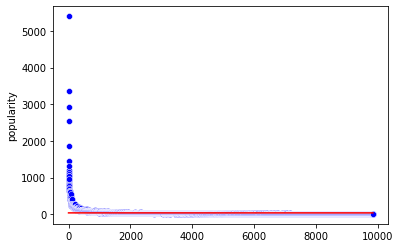

In [ ]:
show_graph(df, "popularity")

vote_average의 평균값 : 6.364509246088183
vote_average의 표준편차 : 1.2947210193713738
vote_average의 최소값 : 0.0
vote_average의 최대값 : 9.5



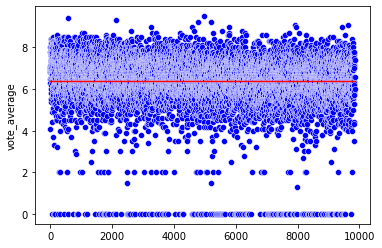

In [ ]:
show_graph(df, "vote_average")

vote_count의 평균값 : 1336.1601300548668
vote_count의 표준편차 : 2516.323136682163
vote_count의 최소값 : 0.0
vote_count의 최대값 : 30184.0



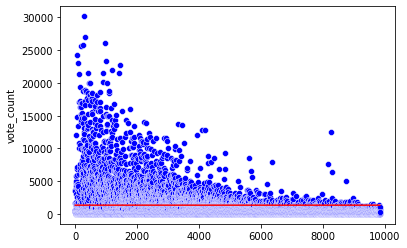

In [ ]:
show_graph(df, "vote_count")

revenue의 평균값 : 58266671.07986182
revenue의 표준편차 : 149077415.48249987
revenue의 최소값 : 0.0
revenue의 최대값 : 2847246203.0



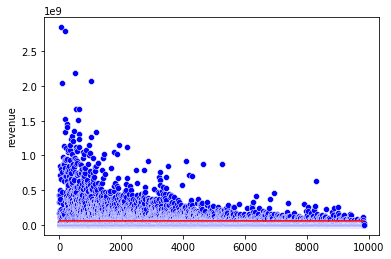

In [ ]:
show_graph(df, "revenue")

그래프를 확인해 본 결과
- popularity의 그래프는 이상치 데이터가 눈에 띄게 보이며 이를 제외하면 가장 평균에 밀집된 형태의 그래프라고 생각합니다.
- vote_count, revenue의 그래프는 서로 비슷한 형태의 그래프를 띠며 0 값들이 많이 존재하고 있습니다.
- vote_average 그래프는 평균을 기준으로 고르게 분포되었지만 0 값들이 많이 존재하고 이는 평균에 영향을 끼칠것 같다고 생각하였습니다.

revenue 값이 0인 데이터를 확인해본 결과, 4501개가 조회되었고

데이터의 절반을 차지하므로 삭제를 할 수 없습니다.

In [ ]:
df.query("revenue == 0")

id original_language                  original_title  popularity  \
3     796499                en                 Army of Thieves    2552.437   
8     871964                pl  W lesie dziś nie zaśnie nikt 2    1089.852   
9     768449                en                 American Badger    1148.822   
11    843241                ja             劇場版 七つの大罪 光に呪われし者たち    1108.815   
14    630004                en                       The Vault    1046.860   
...      ...               ...                             ...         ...   
9836   28752                en       The Curse of the Werewolf       9.017   
9837     530                en                 A Grand Day Out       9.266   
9838   15934                en                     El cantante      10.417   
9839  162215                en                  How I Live Now       9.520   
9841  311667                en                 Manhattan Night       9.273   

      release_date  vote_average  vote_count  \
3         20211027           6.9         555   
8         20211027           4.1          72   
9         20210305           6.3          14   
11        20210702           8.4         210   
14        20210303           7.1         392   
...            ...           ...         ...   
9836      19610501           6.6         110   
9837      19900518           7.5         594   
9838      20060912           7.0          80   
9839      20130910           6.6         705   
9841      20160520           6.0         304   

                                                  genre  revenue  
3                       ['Action', 'Crime', 'Thriller']        0  
8                                ['Horror', 'Thriller']        0  
9                                ['Action', 'Thriller']        0  
11                              ['Animation', 'Action']        0  
14                      ['Crime', 'Action', 'Thriller']        0  
...                                                 ...      ...  
9836                                         ['Horror']        0  
9837  ['Adventure', 'Animation', 'Comedy', 'Science ...        0  
9838                      ['History', 'Drama', 'Music']        0  
9839             ['Drama', 'Action', 'Thriller', 'War']        0  
9841                   ['Drama', 'Mystery', 'Thriller']        0  

[4501 rows x 9 columns]

vote_count와 vote_average의 값이 0인 데이터를 확인해본 결과, 182개가 조회되었고

In [ ]:
df.query("vote_count == 0 and vote_average == 0")

id original_language                     original_title  popularity  \
61    634649                en            Spider-Man: No Way Home     480.702   
114   568124                en                            Encanto     265.395   
131   385687                en                  Fast & Furious 10     211.849   
141   585083                en  Hotel Transylvania: Transformania     190.917   
244   743439                en      PAW Patrol: Jet to the Rescue     157.469   
...      ...               ...                                ...         ...   
9480  660833                en                         Multiverse      13.802   
9501  754848                en       DMX: Don't Try to Understand      10.746   
9520  891023                en                         Hockeyland      13.361   
9533  890349                en                      BUTTERSCOTCH.      14.449   
9713  159734                en                              Suits      11.528   

      release_date  vote_average  vote_count  \
61        20211215           0.0           0   
114       20211124           0.0           0   
131       20230406           0.0           0   
141       20220114           0.0           0   
244       20211202           0.0           0   
...            ...           ...         ...   
9480      20211112           0.0           0   
9501      20211113           0.0           0   
9520      20211112           0.0           0   
9533      20211111           0.0           0   
9713      19990110           0.0           0   

                                                  genre  revenue  
61           ['Action', 'Adventure', 'Science Fiction']        0  
114   ['Family', 'Music', 'Adventure', 'Animation', ...        0  
131                                 ['Action', 'Crime']        0  
141   ['Family', 'Animation', 'Fantasy', 'Comedy', '...        0  
244                             ['Family', 'Animation']        0  
...                                                 ...      ...  
9480                       ['Drama', 'Science Fiction']        0  
9501                           ['Documentary', 'Music']        0  
9520                                    ['Documentary']        0  
9533                                        ['Mystery']        0  
9713                                         ['Comedy']        0  

[182 rows x 9 columns]

revenue의 값 또한 0이여서 삭제를 하였습니다.

In [ ]:
df.query("vote_count == 0 and vote_average == 0").query("revenue == 0")

id original_language                     original_title  popularity  \
61    634649                en            Spider-Man: No Way Home     480.702   
114   568124                en                            Encanto     265.395   
131   385687                en                  Fast & Furious 10     211.849   
141   585083                en  Hotel Transylvania: Transformania     190.917   
244   743439                en      PAW Patrol: Jet to the Rescue     157.469   
...      ...               ...                                ...         ...   
9480  660833                en                         Multiverse      13.802   
9501  754848                en       DMX: Don't Try to Understand      10.746   
9520  891023                en                         Hockeyland      13.361   
9533  890349                en                      BUTTERSCOTCH.      14.449   
9713  159734                en                              Suits      11.528   

      release_date  vote_average  vote_count  \
61        20211215           0.0           0   
114       20211124           0.0           0   
131       20230406           0.0           0   
141       20220114           0.0           0   
244       20211202           0.0           0   
...            ...           ...         ...   
9480      20211112           0.0           0   
9501      20211113           0.0           0   
9520      20211112           0.0           0   
9533      20211111           0.0           0   
9713      19990110           0.0           0   

                                                  genre  revenue  
61           ['Action', 'Adventure', 'Science Fiction']        0  
114   ['Family', 'Music', 'Adventure', 'Animation', ...        0  
131                                 ['Action', 'Crime']        0  
141   ['Family', 'Animation', 'Fantasy', 'Comedy', '...        0  
244                             ['Family', 'Animation']        0  
...                                                 ...      ...  
9480                       ['Drama', 'Science Fiction']        0  
9501                           ['Documentary', 'Music']        0  
9520                                    ['Documentary']        0  
9533                                        ['Mystery']        0  
9713                                         ['Comedy']        0  

[182 rows x 9 columns]

In [ ]:
df.drop(df.query("vote_count == 0 and vote_average == 0").index, inplace=True)
df.reset_index(drop=True, inplace=True)

popularity의 평균이랑 차이가 많이 나는 데이터들을 삭제합니다.

In [ ]:
df.query("popularity > 100")

id original_language                              original_title  \
0    580489                en                 Venom: Let There Be Carnage   
1    524434                en                                    Eternals   
2    438631                en                                        Dune   
3    796499                en                             Army of Thieves   
4    550988                en                                    Free Guy   
..      ...               ...                                         ...   
552      58                en  Pirates of the Caribbean: Dead Man's Chest   
562  736073                en        Batman: The Long Halloween, Part One   
581  522931                en                   Hitman's Wife's Bodyguard   
652  775943                es                              Llanto Maldito   
655  206647                en                                     Spectre   

     popularity  release_date  vote_average  vote_count  \
0      5401.308      20210930           6.8        1736   
1      3365.535      20211103           7.1         622   
2      2911.423      20210915           8.0        3632   
3      2552.437      20211027           6.9         555   
4      1850.470      20210811           7.8        3493   
..          ...           ...           ...         ...   
552     107.364      20060706           7.3       12734   
562     107.078      20210621           7.9         264   
581     111.297      20210614           7.0         859   
652     119.624      20210729           3.7           6   
655     110.665      20151026           6.5        8662   

                                                 genre     revenue  
0           ['Science Fiction', 'Action', 'Adventure']   424000000  
1    ['Action', 'Adventure', 'Science Fiction', 'Fa...   165000000  
2           ['Action', 'Adventure', 'Science Fiction']   331116356  
3                      ['Action', 'Crime', 'Thriller']           0  
4    ['Comedy', 'Action', 'Adventure', 'Science Fic...   331096766  
..                                                 ...         ...  
552                 ['Adventure', 'Fantasy', 'Action']  1065659812  
562        ['Animation', 'Mystery', 'Action', 'Crime']           0  
581                   ['Action', 'Comedy', 'Thriller']    69212098  
652                                         ['Horror']           0  
655                ['Action', 'Adventure', 'Thriller']   880674609  

[447 rows x 9 columns]

In [ ]:
df.drop(df.query("popularity > 100").index, inplace=True)
df.reset_index(drop=True, inplace=True)

popularity의 평균값 : 23.148248236187968
popularity의 표준편차 : 17.478814173500876
popularity의 최소값 : 6.269
popularity의 최대값 : 99.96



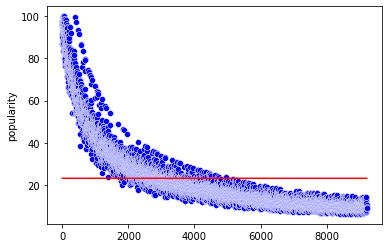

In [ ]:
show_graph(df, "popularity")

vote_average의 평균값 : 6.469760121567351
vote_average의 표준편차 : 0.9574555567022587
vote_average의 최소값 : 1.3
vote_average의 최대값 : 9.5



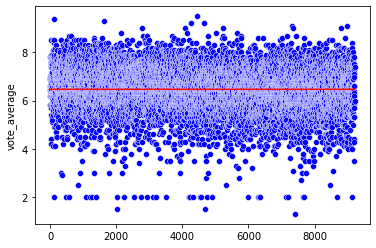

In [ ]:
show_graph(df, "vote_average")

vote_count의 평균값 : 1244.0678389232605
vote_count의 표준편차 : 2222.6899262639668
vote_count의 최소값 : 1.0
vote_count의 최대값 : 26148.0



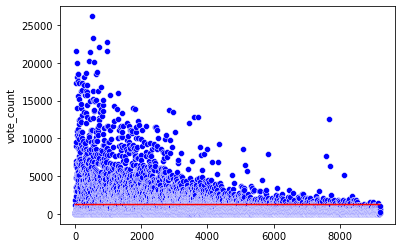

In [ ]:
show_graph(df, "vote_count")

revenue의 평균값 : 51706386.15011397
revenue의 표준편차 : 124358173.23039126
revenue의 최소값 : 0.0
revenue의 최대값 : 2187463944.0



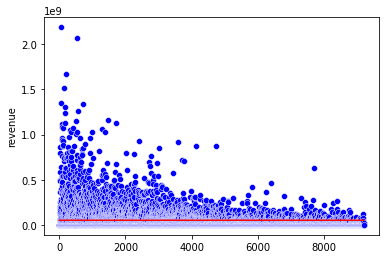

In [ ]:
show_graph(df, "revenue")

## 6. 새로운 열 생성

In [ ]:
genres = []

for i, genre in enumerate(df["genre"]):
  genre_list = genre.replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(",")

  genre_str = ""
  for j, item in enumerate(genre_list):
    genre_str = genre_str + item
    if j < len(genre_list) - 1:
      genre_str = genre_str + ","
    if item not in genres:
      genres.append(item)

  df.loc[i, "genre"] = genre_str

print(len(genres))
print(genres)

19
['Drama', 'Comedy', 'Crime', 'Mystery', 'Thriller', 'War', 'Horror', 'Action', 'ScienceFiction', 'Romance', 'Adventure', 'Fantasy', 'Animation', 'Family', 'Documentary', 'History', 'Western', 'TVMovie', 'Music']


In [ ]:
for genre in genres:
  df[genre] = 0

df.columns

Index(['id', 'original_language', 'original_title', 'popularity',
       'release_date', 'vote_average', 'vote_count', 'genre', 'revenue',
       'Drama', 'Comedy', 'Crime', 'Mystery', 'Thriller', 'War', 'Horror',
       'Action', 'ScienceFiction', 'Romance', 'Adventure', 'Fantasy',
       'Animation', 'Family', 'Documentary', 'History', 'Western', 'TVMovie',
       'Music'],
      dtype='object')

In [ ]:
for index, genre in enumerate(df["genre"]):
  genre_list = genre.split(",")
  for item in genre_list:
    if item in df.columns:
      df.loc[index, item] = 1

df.drop(["genre"], axis=1, inplace=True)

In [ ]:
df.columns

Index(['id', 'original_language', 'original_title', 'popularity',
       'release_date', 'vote_average', 'vote_count', 'revenue', 'Drama',
       'Comedy', 'Crime', 'Mystery', 'Thriller', 'War', 'Horror', 'Action',
       'ScienceFiction', 'Romance', 'Adventure', 'Fantasy', 'Animation',
       'Family', 'Documentary', 'History', 'Western', 'TVMovie', 'Music'],
      dtype='object')

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 회귀(Regression) : 영화 수익 예측하기

프로젝트 목표 : 데이터셋을 사용하여 머신러닝 모델을 만든 후 성능 및 인사이트를 도출 / 공유하는 것

문제 : 영화관의 수익을 올리기 위해 수익이 높을 것 같은 영화를 큰 상영관에 상영하고 상영 횟수를 높이며 수익이 적을 것 같은 영화는 작은 상영관에 상영하고 상영 횟수를 줄입니다. 이로 인해 상영관의 빈 좌석을 줄이는 것이 목표입니다. 그러면 수익이 높은 영화를 어떻게 예측해야할까요?


##모델 성능 평가

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def Model_Performance_Evaluation_Indicators(y_train, y_pred_train, y_test, y_pred_test):
  if y_train is not None and y_pred_train is not None:
    train_mse = round(mean_squared_error(y_train, y_pred_train), 2)
    train_mae = round(mean_absolute_error(y_train, y_pred_train), 2)
    train_rmse = round(train_mse**0.5, 2)
    train_r2 = round(r2_score(y_train, y_pred_train), 1)

    print("훈련 데이터에 대한 MSE : {}".format(train_mse))
    print("훈련 데이터에 대한 MAE : {}".format(train_mae))
    print("훈련 데이터에 대한 RMSE : {}".format(train_rmse))
    print("훈련 데이터에 대한 R^2 : {}\n".format(train_r2))

  if y_test is not None and y_pred_test is not None:
    test_mse = round(mean_squared_error(y_test, y_pred_test), 2)
    test_mae = round(mean_absolute_error(y_test, y_pred_test), 2)
    test_rmse = round(test_mse**0.5, 2)
    test_r2 = round(r2_score(y_test, y_pred_test), 1)

    print("테스트 데이터에 대한 MSE : {}".format(test_mse))
    print("테스트 데이터에 대한 MAE : {}".format(test_mae))
    print("테스트 데이터에 대한 RMSE : {}".format(test_rmse))
    print("테스트 데이터에 대한 R^2 : {}\n".format(test_r2))

## 타겟과의 상관계수 및 기준모델(Baseline Model)

In [ ]:
target = 'revenue'

features = df.corr().sort_values(by=target, ascending=False)[target]
feature = features.index[1]

print("타겟({})과의 상관계수 : \n{}".format(target, features))
print("타겟({})과의 상관계수가 가장 높은 특성 : {}".format(target, feature))

타겟(revenue)과의 상관계수 : 
revenue           1.000000
vote_count        0.739401
popularity        0.402381
Adventure         0.244253
Action            0.138300
vote_average      0.123041
Family            0.092618
Fantasy           0.088601
ScienceFiction    0.076060
Comedy            0.034028
War               0.020148
Animation         0.009160
Romance           0.002734
Western          -0.000413
History          -0.000620
Crime            -0.004755
Music            -0.013456
Thriller         -0.016624
Mystery          -0.017702
release_date     -0.033301
Drama            -0.060983
Documentary      -0.066748
TVMovie          -0.066890
Horror           -0.095781
id               -0.211408
Name: revenue, dtype: float64
타겟(revenue)과의 상관계수가 가장 높은 특성 : vote_count


훈련 데이터에 대한 MSE : 6.452665695966966e+16
훈련 데이터에 대한 MAE : 113618436.88
훈련 데이터에 대한 RMSE : 254020977.4
훈련 데이터에 대한 R^2 : -3.2



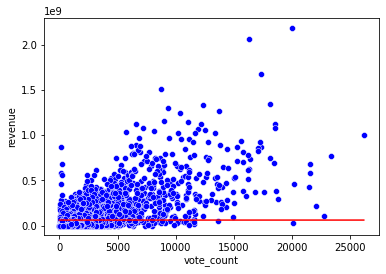

In [ ]:
X_train = df[feature]

y_train = df[target]
y_pred = y_train.mean() - y_train

Model_Performance_Evaluation_Indicators(y_train, y_pred, None, None)

sns.lineplot(x=X_train, y=predict, color='red')
sns.scatterplot(x=X_train, y=y_train, color='blue');

##데이터셋 train/validation/test 분류

In [ ]:
train = df.query("release_date < 20210000")
test = df.query("release_date >= 20210000")

val_len = len(test) * 2
train_len = len(train) - val_len

val = train.sort_values("release_date")[-val_len:]
train = train.sort_values("release_date")[:train_len]

print("훈련 세트 : {}".format(train.shape))
print("검증 세트 : {}".format(val.shape))
print("테스트 세트 : {}".format(test.shape))

훈련 세트 : (7797, 27)
검증 세트 : (944, 27)
테스트 세트 : (472, 27)


훈련 세트

In [ ]:
train

id original_language                         original_title  \
7678     775                fr                 Le Voyage dans la Lune   
6352     234                de           Das Cabinet des Dr. Caligari   
6448     653                de  Nosferatu, eine Symphonie des Grauens   
9082     669                en                    Nanook of the North   
8310   22596                en                           Safety Last!   
...      ...               ...                                    ...   
3938  411728                en           The Professor and the Madman   
7344  491473                en                            Gloria Bell   
6137  587727                ko                              가슴 큰 여자친구   
8908  581420                en                     Walk. Ride. Rodeo.   
3455  400157                en                            Wonder Park   

      popularity  release_date  vote_average  vote_count    revenue  Drama  \
7678      12.469      19020417           8.0        1223          0      0   
6352       9.258      19200227           7.9        1019       8811      1   
6448      12.428      19220217           7.7        1335      19054      1   
9082       9.528      19220611           7.1         189          0      0   
8310      10.377      19230401           7.9         303    1500000      0   
...          ...           ...           ...         ...        ...    ...   
3938      23.022      20190307           7.2         782    4957273      1   
7344       9.041      20190307           5.9         225          0      1   
6137      11.548      20190308           7.4           7          0      0   
8908      11.066      20190308           7.0         175          0      1   
3455      21.072      20190313           6.4         518  119559110      0   

      Comedy  ...  Romance  Adventure  Fantasy  Animation  Family  \
7678       0  ...        0          1        1          0       0   
6352       0  ...        0          0        0          0       0   
6448       0  ...        0          0        1          0       0   
9082       0  ...        0          1        0          0       0   
8310       1  ...        1          0        0          0       0   
...      ...  ...      ...        ...      ...        ...     ...   
3938       0  ...        0          0        0          0       0   
7344       0  ...        1          0        0          0       0   
6137       0  ...        1          0        0          0       0   
8908       0  ...        0          0        0          0       0   
3455       1  ...        0          1        1          1       1   

      Documentary  History  Western  TVMovie  Music  
7678            0        0        0        0      0  
6352            0        0        0        0      0  
6448            0        0        0        0      0  
9082            1        0        0        0      0  
8310            0        0        0        0      0  
...           ...      ...      ...      ...    ...  
3938            0        1        0        0      0  
7344            0        0        0        0      0  
6137            0        0        0        0      0  
8908            0        0        0        0      0  
3455            0        0        0        0      0  

[7797 rows x 27 columns]

검증 세트

In [ ]:
val

id original_language                       original_title  \
7132  291984                en  The Death & Life of John F. Donovan   
7686  573227                es                        La mala noche   
3039  416144                en                         Hotel Mumbai   
447   527641                en                      Five Feet Apart   
1660  458723                en                                   Us   
...      ...               ...                                  ...   
53    615677                en                     We Can Be Heroes   
2922  652837                ja                            ジョゼと虎と魚たち   
1699  581032                en                    News of the World   
4966  773655                en                        Death to 2020   
7143  641662                en                    Pieces of a Woman   

      popularity  release_date  vote_average  vote_count    revenue  Drama  \
7132      11.734      20190313           7.0         583          0      1   
7686       9.724      20190313           4.5           8          0      1   
3039      23.314      20190314           7.6        1079   16872691      1   
447       66.267      20190314           8.4        4452   91500000      1   
1660      35.133      20190314           7.0        5418  255105930      0   
...          ...           ...           ...         ...        ...    ...   
53        97.081      20201225           6.3         544          0      0   
2922      21.000      20201225           8.7         135          0      1   
1699      29.383      20201225           7.0        1180          0      0   
4966      14.725      20201227           6.6         473          0      0   
7143       9.873      20201230           7.1         828          0      1   

      Comedy  ...  Romance  Adventure  Fantasy  Animation  Family  \
7132       0  ...        0          0        0          0       0   
7686       0  ...        0          0        0          0       0   
3039       0  ...        0          0        0          0       0   
447        0  ...        1          0        0          0       0   
1660       0  ...        0          0        0          0       0   
...      ...  ...      ...        ...      ...        ...     ...   
53         1  ...        0          0        1          0       1   
2922       0  ...        1          0        0          1       0   
1699       0  ...        0          1        0          0       0   
4966       1  ...        0          0        0          0       0   
7143       0  ...        0          0        0          0       0   

      Documentary  History  Western  TVMovie  Music  
7132            0        0        0        0      0  
7686            0        0        0        0      0  
3039            0        1        0        0      0  
447             0        0        0        0      0  
1660            0        0        0        0      0  
...           ...      ...      ...      ...    ...  
53              0        0        0        0      0  
2922            0        0        0        0      0  
1699            0        0        1        0      0  
4966            0        0        0        0      0  
7143            0        0        0        0      0  

[944 rows x 27 columns]

테스트 세트

In [ ]:
test

id original_language  \
0     669659                en   
1     649409                en   
2     645710                en   
4     857910                es   
8     786300                en   
...      ...               ...   
9137  597859                ru   
9196  586791                en   
9203  873633                en   
9205  799555                en   
9206  554594                en   

                                         original_title  popularity  \
0                                          Best Sellers      97.152   
1                                        No Sudden Move      91.432   
2                                           The Voyeurs      95.844   
4                                Lokillo: nada es igual      97.682   
8                                             Tentacles      93.795   
...                                                 ...         ...   
9137                                             Лётчик       8.179   
9196                                        Little Fish       8.964   
9203                                        Honey Girls      14.151   
9205  Operation Varsity Blues: The College Admission...       9.304   
9206                                              Koati       8.020   

      release_date  vote_average  vote_count  revenue  Drama  Comedy  ...  \
0         20210909           6.4          23        0      1       1  ...   
1         20210624           6.5         278        0      1       0  ...   
2         20210825           6.9         268        0      0       0  ...   
4         20210812           7.8          15        0      0       1  ...   
8         20210212           6.2          83        0      0       0  ...   
...            ...           ...         ...      ...    ...     ...  ...   
9137      20211104           2.0           1        0      1       0  ...   
9196      20210205           7.2          71    39053      1       0  ...   
9203      20211019           4.3           4        0      0       0  ...   
9205      20210317           7.1          82        0      1       0  ...   
9206      20210805           3.5           2        0      0       0  ...   

      Romance  Adventure  Fantasy  Animation  Family  Documentary  History  \
0           0          0        0          0       0            0        0   
1           0          0        0          0       0            0        0   
2           0          0        0          0       0            0        0   
4           0          0        0          0       0            0        0   
8           1          0        0          0       0            0        0   
...       ...        ...      ...        ...     ...          ...      ...   
9137        0          0        0          0       0            0        1   
9196        1          0        0          0       0            0        0   
9203        0          0        0          0       1            0        0   
9205        0          0        0          0       0            1        0   
9206        0          0        0          1       0            0        0   

      Western  TVMovie  Music  
0           0        0      0  
1           0        0      0  
2           0        0      0  
4           0        0      0  
8           0        0      0  
...       ...      ...    ...  
9137        0        0      0  
9196        0        0      0  
9203        0        0      1  
9205        0        0      0  
9206        0        0      1  

[472 rows x 27 columns]

## 단순 선형 회귀(Simple Linear Regression)

In [ ]:
from sklearn.linear_model import LinearRegression

X_train = train[[feature]]
y_train = train[[target]]

X_val = val[[feature]]
y_val = val[[target]]

X_test = test[[feature]]
y_test = test[[target]]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Model_Performance_Evaluation_Indicators(y_train, y_pred_train, y_test, y_pred_test)
  
print('검증 세트 정확도 : {}'.format(model.score(X_val, y_val)))
print('테스트 세트 정확도 : {}'.format(model.score(X_test, y_test)))

훈련 데이터에 대한 MSE : 9640664619742080.0
훈련 데이터에 대한 MAE : 45809919.9
훈련 데이터에 대한 RMSE : 98186886.19
훈련 데이터에 대한 R^2 : 0.6

테스트 데이터에 대한 MSE : 2214234028186659.0
테스트 데이터에 대한 MAE : 13253265.29
테스트 데이터에 대한 RMSE : 47055648.21
테스트 데이터에 대한 R^2 : 0.5

검증 세트 정확도 : 0.5160176622644587
테스트 세트 정확도 : 0.4585315590063218


## 다중 선형 회귀(Multiple Linear Regression)

In [ ]:
features = ['vote_count', 'vote_average']

y_train = train[target]
X_train = train[features]

y_val = val[target]
X_val = val[features]

y_test = test[target]
X_test = test[features]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

Model_Performance_Evaluation_Indicators(y_train, y_pred_train, y_test, y_pred_test)
  
print('검증 세트 정확도 : {}'.format(model.score(X_val, y_val)))
print('테스트 세트 정확도 : {}'.format(model.score(X_test, y_test)))

훈련 데이터에 대한 MSE : 7689535101790962.0
훈련 데이터에 대한 MAE : 43394706.12
훈련 데이터에 대한 RMSE : 87689994.31
훈련 데이터에 대한 R^2 : 0.6

테스트 데이터에 대한 MSE : 606807862440341.9
테스트 데이터에 대한 MAE : 15971289.2
테스트 데이터에 대한 RMSE : 24633470.37
테스트 데이터에 대한 R^2 : -2.9

검증 세트 정확도 : 0.38510509137897775
테스트 세트 정확도 : -2.9252375580140972


## Ridge Regression

In [ ]:
import numpy as np

from category_encoders import OneHotEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

features = ['original_language', 'popularity', 'vote_average', 'vote_count',
            'ScienceFiction', 'Action', 'Adventure', 'Fantasy', 'Crime', 
            'Thriller', 'Comedy', 'Horror', 'Animation', 'Family', 'Mystery', 
            'Drama', 'Romance', 'Music', 'Western', 'TVMovie', 'History', 
            'War', 'Documentary']

y_train = train[target]
X_train = train[features]

y_val = val[target]
X_val = val[features]

y_test = test[target]
X_test = test[features]

estimator = make_pipeline(OneHotEncoder(cols=['original_language'], use_cat_names=True),
                          SimpleImputer(strategy='mean'),
                          StandardScaler(),
                          SelectKBest(f_regression),
                          RidgeCV())

cross_val = {
    'estimator' : estimator,
    'X' : X_train, 
    'y' : y_train, 
    'groups' : None, 
    'scoring' : None, 
    'cv' : 3, 
    'n_jobs' : None, 
    'verbose' : 0, 
    'fit_params' : None, 
    'pre_dispatch' : '2*n_jobs', 
    'error_score' : np.nan
}

scores = cross_val_score(estimator=cross_val['estimator'], 
                         X=cross_val['X'], 
                         y=cross_val['y'], 
                         groups=cross_val['groups'], 
                         scoring=cross_val['scoring'], 
                         cv=cross_val['cv'], 
                         n_jobs=cross_val['n_jobs'], 
                         verbose=cross_val['verbose'], 
                         fit_params=cross_val['fit_params'], 
                         pre_dispatch=cross_val['pre_dispatch'], 
                         error_score=cross_val['error_score'])

print(f'MAE ({cross_val["cv"]} folds):', -scores)

MAE (3 folds): [-0.41463893 -0.67063216 -0.64344222]


In [ ]:
param_grid = {
    'selectkbest__k' : range(1, len(X_train.columns)+1), 
    'ridgecv__alphas' : range(1, 10), 
    'ridgecv__cv' : range(1, 5)
}

searchCV = {
    'estimator' : estimator,
    'param_grid' : param_grid,
    'scoring' : 'accuracy',
    'n_jobs' : 1,
    'refit' : True,
    'cv' : 3,
    'verbose' : 10,
    'pre_dispatch' : '2*n_jobs',
    'error_score' : np.nan,
    'return_train_score' : True
}

gridSearchCV = GridSearchCV(estimator=searchCV['estimator'], 
                            param_grid=searchCV['param_grid'], 
                            scoring=searchCV['scoring'], 
                            n_jobs=searchCV['n_jobs'], 
                            refit=searchCV['refit'], 
                            cv=searchCV['cv'], 
                            verbose=searchCV['verbose'], 
                            pre_dispatch=searchCV['pre_dispatch'], 
                            error_score=searchCV['error_score'], 
                            return_train_score=searchCV['return_train_score'])

gridSearchCV.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', gridSearchCV.best_params_)
print('MAE: ', -gridSearchCV.best_score_)

[CV 3/3; 219/828] END ridgecv__alphas=3, ridgecv__cv=2, selectkbest__k=12;, score=(train=nan, test=nan) total time=   0.1s
[CV 1/3; 220/828] START ridgecv__alphas=3, ridgecv__cv=2, selectkbest__k=13.....
[CV 1/3; 220/828] END ridgecv__alphas=3, ridgecv__cv=2, selectkbest__k=13;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/3; 220/828] START ridgecv__alphas=3, ridgecv__cv=2, selectkbest__k=13.....
[CV 2/3; 220/828] END ridgecv__alphas=3, ridgecv__cv=2, selectkbest__k=13;, score=(train=nan, test=nan) total time=   0.1s
[CV 3/3; 220/828] START ridgecv__alphas=3, ridgecv__cv=2, selectkbest__k=13.....
[CV 3/3; 220/828] END ridgecv__alphas=3, ridgecv__cv=2, selectkbest__k=13;, score=(train=nan, test=nan) total time=   0.1s
[CV 1/3; 221/828] START ridgecv__alphas=3, ridgecv__cv=2, selectkbest__k=14.....
[CV 1/3; 221/828] END ridgecv__alphas=3, ridgecv__cv=2, selectkbest__k=14;, score=(train=nan, test=nan) total time=   0.1s
[CV 2/3; 221/828] START ridgecv__alphas=3, ridgecv__cv=2, sel

KeyboardInterrupt: ignored